In [1]:
import subprocess
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import json
import logging
import datetime
from importlib import reload
import collections
import os
import math
from sklearn.linear_model import LinearRegression
import datetime
reload(logging)
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

2023-05-18 17:31:03 INFO     use_busd_comission=False
2023-05-18 17:31:03 INFO     len(log)=2725


no comm pnl = -116.48511 no comm/tier4 =  354.0849817757921
tier4 pnl = -0.32898 tier4/tier4 =  1.0
0.6940018407789115
tier5 pnl = 28.71006 tier5/tier4 =  -87.27124544394799


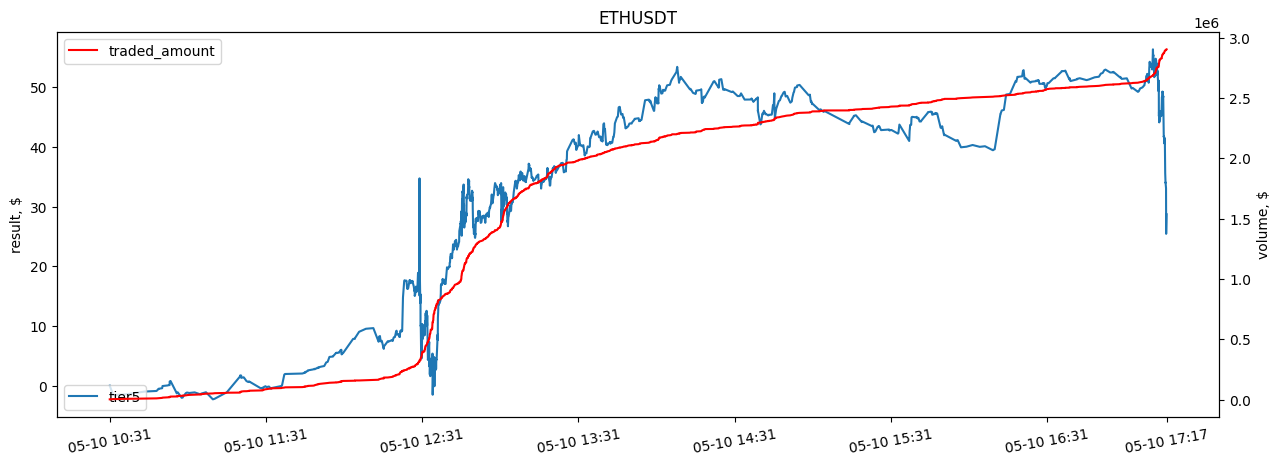

In [3]:
pairs_cnt = len(instruments_config['sections'][0]['id_by_symbol'].items())
fig=plt.figure(figsize=(15,5 * pairs_cnt))

def sharpe(x_):
    x = []
    for i in range(1, len(x_)):
        x.append(x_[i] - x_[i - 1])
    return np.mean(x) / np.std(x) * np.sqrt(len(x))


PNL, TS = [], []
for pair_index, (pair, need_id_instr) in enumerate(instruments_config['sections'][0]['id_by_symbol'].items()):
    log = list()

    use_busd_comission = False
    if pair.endswith('BUSD'):
        use_busd_comission = True
    logging.info(f'{use_busd_comission=}')

    ids_order = {}
    for line in line_parsed:
        if 'add_limit_order' in line:
            row = json.loads(line)
            if row['instrument_id']['id'] == need_id_instr:
                ids_order[row['order_id']] = True
        if 'Execution' not in line:
            continue
        row = json.loads(line)
        if ids_order.get(row['order_id']) is None:
            continue
        if row['type'] != 'order_update' or 'Execution' not in row['event']:
            continue
        log.append(row)
    logging.info(f'{len(log)=}')


    comissions_to_calc = {
        "no comm": 0.0,
        "default_pnl": 0.00012 if use_busd_comission else 0.0003
    }
    pnl = list()
    ts = list()
    cur_fiat_amount = 0.0
    cur_crypto_amount = 0.0
    traded_amount = 0.0  
    pnl.append([0, 0, 0, 0])
    for elem in log:
        data = elem['event']['Execution']
        dir, price, amount = data['dir'], float(data['price']), float(data['amount'])
        cur_line = list()
        traded_amount += amount
        cur_line.append(pnl[-1][0] + price * amount)
        if dir == 'Ask':
            cur_crypto_amount -= amount
            cur_fiat_amount += amount * price
        else:
            cur_crypto_amount += amount
            cur_fiat_amount -= amount * price

        for i, comm in enumerate(comissions_to_calc.values()):
            cur_pnl = cur_crypto_amount * price + cur_fiat_amount - cur_line[0] * comm
            cur_line.append(cur_pnl)
        cur_line.append(cur_crypto_amount)
        cur_line.append(amount * price)
        pnl.append(cur_line)
        ts.append(elem['exchange_time'] / 1e9)
    pnl = pnl[1:]
    PNL = pnl
    ts=[datetime.datetime.fromtimestamp(t) for t in ts]
    TS = ts

    if len(ts) == 0:
        continue


    ax1=plt.subplot(pairs_cnt, 1, pair_index + 1)
    ax1.set_title(pair)
    ax2=ax1.twinx()

    xfmt = md.DateFormatter('%m-%d %H:%M')
    ax1.xaxis.set_major_formatter(xfmt)

    xticks_formats = np.array([1/3, 1, 2, 4, 12, 24]) # in hours
    xticks_formats *= 10**6 * 60**2
    for elem in xticks_formats:
        xticks = np.append(np.arange(min(ts), max(ts) - datetime.timedelta(microseconds=elem/5), int(elem)), ts[-1])
        if len(xticks) < 10:
            break

    plt.setp(ax1, xticks=xticks)
    plt.setp(ax1.get_xticklabels(), rotation=10)

    for i, name in enumerate(comissions_to_calc.keys()):
        if name in ['tier2', 'tier3']:
            continue
        if name in ['tier5']:
            ax1.plot(ts, [x[i + 1] for x in pnl], label=name)
            print(sharpe([x[i + 1] for x in pnl]))
        print(name, 'pnl =', round(pnl[-1][i + 1], 5), f'{name}/tier4 = ', pnl[-1][i + 1] / pnl[-1][4])

    ax2.plot(ts, [x[0] for x in pnl], label='traded_amount', c='r')
  

    ax1.legend(loc='lower left')
    ax2.legend(loc='upper left')
    ax1.set_ylabel('result, $')
    ax2.set_ylabel('volume, $') 

plt.show()

=========== Summary ===========
Sharpe ratio: 0.5
Sortino ratio: 0.3
Annualised return: 3717.06 %
Max. draw down: 3.61 %
The number of trades per day: 2725
Avg. daily trading volume: 2903903
Avg. daily trading amount: 1573
Max leverage: 0.01
Median leverage: 0.00


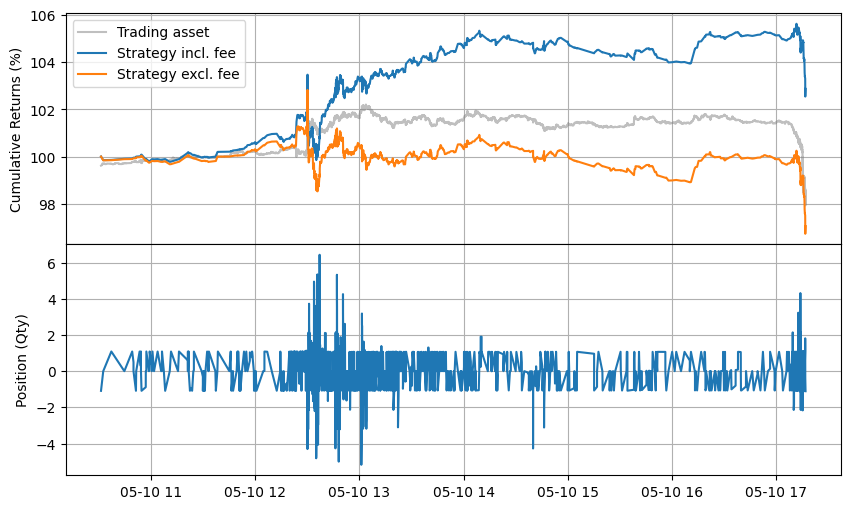

In [4]:
eth0510 = pd.read_csv('/home/abobus/research/data/ETHBUSD-aggTrades-2023-05-10.csv')

capital = 1000.

prib = [x[5] for x in pnl]
equity =  pd.Series([x[5] for x in pnl])
rs_equity_wo_fee =  pd.Series([x[1] for x in pnl])
rs_equity = equity
rs_pnl = rs_equity.diff()

trading_days = 365
c = (24 * 60 * 60) / (TS[-1] - TS[0]).seconds
sr = np.divide(rs_pnl.mean(), rs_pnl.std()) * np.sqrt(c * trading_days)

std = rs_pnl[rs_pnl < 0].std()
sortino = np.divide(rs_pnl.mean(), std) * np.sqrt(c * trading_days)

max_equity = rs_equity.cummax()
drawdown = rs_equity - max_equity
mdd = -drawdown.min()

ac = (24 * 60 * 60) / (TS[-1] - TS[0]).seconds
ar = prib[-1] * ac * trading_days
rrr = ar / mdd


print('=========== Summary ===========')
print('Sharpe ratio: %.1f' % sr)
print('Sortino ratio: %.1f' % sortino)
# print('Risk return ratio: %.1f' % rrr)
if capital is not None:
    print('Annualised return: %.2f %%' % (ar / capital * 100))
    print('Max. draw down: %.2f %%' % (mdd / capital * 100))
else:
    print('Annualised return: %.2f' % ar)
    print('Max. draw down: %.2f' % mdd)
print('The number of trades per day: %d' % len([x[0] for x in pnl]))
print('Avg. daily trading volume: %d' % [x[0] for x in pnl][-1])
print('Avg. daily trading amount: %d' % int([x[0] for x in pnl][-1] // eth0510.price[0]))

position = np.array([x[-2] for x in PNL])
if capital is not None:
    print('Max leverage: %.2f' % (np.max(np.abs(position)) / capital))
    print('Median leverage: %.2f' % (np.median(np.abs(position)) / capital))

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 6)

inds = (eth0510.transact_time > TS[0].timestamp() *1000) & (eth0510.transact_time < TS[-1].timestamp() *1000)
mid = pd.Series(np.array(eth0510.price[inds]) / eth0510.price[0] * 100)



axs[0].plot([datetime.datetime.fromtimestamp(t//1000) for t in eth0510.transact_time[inds]], mid,  color='grey', alpha=0.5)
axs[0].plot(TS, np.array([x[5] for x in pnl])/capital * 100 + 100)
axs[0].plot(TS, np.array([x[3] for x in pnl])/capital * 100 + 100)

# axs[0].set_title('Equity')
axs[0].set_ylabel('Cumulative Returns (%)')
axs[0].grid()
axs[0].legend(['Trading asset', 'Strategy incl. fee', 'Strategy excl. fee'])

position = pd.Series(position)
axs[1].plot(TS, position)
axs[1].set_ylabel('Position (Qty)')
axs[1].grid()


,agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
0,200437681,1846.04,0.003,390204108,390204108,1683676801739,True
1,200437682,1846.05,0.404,390204109,390204110,1683676805747,False
2,200437683,1846.04,0.719,390204111,390204112,1683676805769,True
3,200437684,1846.05,0.382,390204113,390204114,1683676805798,False
4,200437685,1846.04,0.061,390204115,390204115,1683676805898,True
...,...,...,...,...,...,...,...
209689,200647370,1840.46,0.018,390635573,390635574,1683763191669,True
209690,200647371,1840.47,0.037,390635575,390635575,1683763196517,False
209691,200647372,1840.47,0.055,390635576,390635576,1683763198558,False
209692,200647373,1840.46,0.740,390635577,390635578,1683763198578,True
